**Практика 4: Атака DeepFool на модели ИИ**

**Выполнил: Очередько Антон Николаевич ББМО-01-23**


Шаг 1: Загрузка обученной модели и данных MNIST

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в one-hot кодировку
test_labels = to_categorical(test_labels, 10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0878
Test accuracy on clean images: 0.9768000245094299


Шаг 2-3: Теория и реализация атаки DeepFool с использованием Foolbox

In [17]:
!pip install foolbox --upgrade


Метка:  2


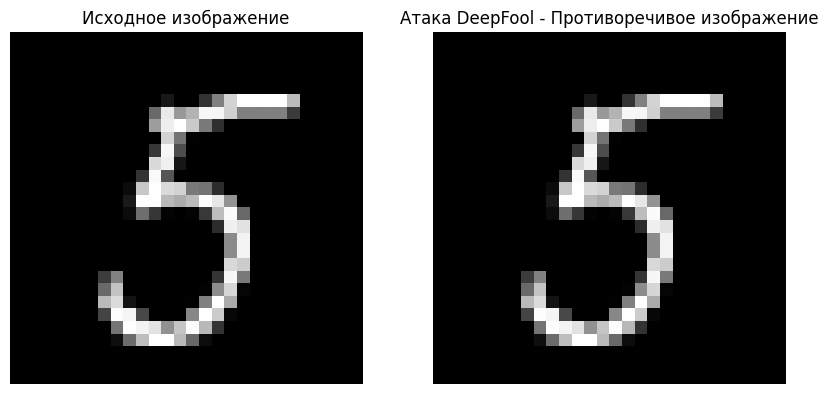

In [40]:
import foolbox as fb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Создание модели Foolbox с заданными пределами значений
model_foolbox = fb.TensorFlowModel(model, bounds=(-1, 1))

# Получение тестового изображения и метки
input_image = tf.convert_to_tensor(test_images[253], dtype=tf.float32)[None, ...]  # 253 индекс из набора
true_label = np.argmax(test_labels[1])  # Метка
true_label_tensor = tf.convert_to_tensor(true_label, dtype=tf.int64)  # Преобразуем метку в тензор

# Настройка атаки и выполнение
deepfool_attack = fb.attacks.L2DeepFoolAttack(steps=150)
print("Метка: ", true_label)
adversarial_images, _, attack_success = deepfool_attack(model_foolbox, input_image, true_label_tensor[None], epsilons=0.02)

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Исходное изображение")
plt.imshow(input_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Атака DeepFool - Противоречивое изображение")
plt.imshow(adversarial_images[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

Шаг 4: Оценка модели на противоречивых примерах

In [49]:
import foolbox as fb
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# Создание модели Foolbox
model_foolbox = fb.TensorFlowModel(model, bounds=(-1, 1))

# Создание набора противоречивых примеров для набора
adversarial_images = []

# Обработка изображений
for i in tqdm(range(len(test_images)), desc="Generating adversarial examples", ncols=100):
    input_image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Обрабатываем изображение для набора
    true_label = np.argmax(test_labels[i])  # Индекс класса
    true_label_tensor = tf.convert_to_tensor(true_label, dtype=tf.int64)  # Преобразуем метку в тензор

    # Выполнение атаки
    adversarial_example, _, attack_success = deepfool_attack(model_foolbox, input_image, true_label_tensor[None], epsilons=0.01)
    adversarial_images.append(adversarial_example)

# Объединение всех противоречивых примеров в один тензор
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')



Generating adversarial examples: 100%|████████████████████████| 10000/10000 [21:31<00:00,  7.74it/s]


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 130.6271
Accuracy on adversarial examples (DeepFool): 0.0


Шаг 5: Вывод

Модель не смогла правильно классифицировать ни одно из атакованных изображений. Это свидетельствует о том, что атака DeepFool была успешной, и модель была сильно уязвима к этим противоречивым примерам.

Потери модели на атакованных примерах составили 130.63, что указывает на значительное ухудшение её производительности. Это также подтверждает, что атака оказалась эффективной, и модель не справляется с классификацией противоречивых примеров.

